# Practical Application 1 – Coupon Analysis

**Goal:** Explore the `coupons` dataset to understand differences between customers who accepted a coupon and those who did not, using pandas, Matplotlib, and Seaborn.


## =========================================


In [1]:
# Practical Application 1 - Coupon Analysis
# "Will the Customer Accept the Coupon?"
# =========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 20)

sns.set(style="whitegrid", context="notebook")



## 1. Read in the coupons.csv file


In [2]:

data = pd.read_csv("coupons.csv")  
print("Raw shape:", data.shape)
data.head()



Raw shape: (12684, 26)


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


## 2. Investigate missing or problematic data


In [3]:

print("\n--- Basic info ---")
data.info()

print("\n--- Missing values per column ---")
missing_counts = data.isna().sum().sort_values(ascending=False)
print(missing_counts)

# Peek at some key categorical columns to understand their values
key_cats = ["coupon", "Y", "Bar", "RestaurantLessThan20", "CoffeeHouse",
            "age", "gender", "passanger", "maritalStatus", "income"]
for col in key_cats:
    if col in data.columns:
        print(f"\nValue counts for {col}:")
        print(data[col].value_counts(dropna=False).head(10))




--- Basic info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar             

## 3. Handle missing data


In [4]:
# Strategy (simple and explicit):
#   - Drop rows where outcome Y or coupon type is missing (cannot use them).
#   - For numeric columns, fill missing values with the median.
#   - For categorical columns, fill missing values with "Unknown".


df = data.copy()

# Drop rows with missing critical fields
critical_cols = [c for c in ["coupon", "Y"] if c in df.columns]
df = df.dropna(subset=critical_cols)

# Fill numeric columns with median
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill categorical columns with "Unknown"
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    df[col].fillna("Unknown", inplace=True)

print("Cleaned shape:", df.shape)
df.head()



Cleaned shape: (12684, 26)


,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,Unknown,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,Unknown,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,Unknown,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,Unknown,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,Unknown,4~8,1~3,1,1,0,0,1,0


## 4. Overall acceptance proportion


In [5]:

if "Y" not in df.columns:
    raise KeyError("Column 'Y' (acceptance flag) was not found in the data.")

overall_accept_rate = df["Y"].mean()  # assumes Y is 0/1
print(f"Overall coupon acceptance rate: {overall_accept_rate:.3f}")



Overall coupon acceptance rate: 0.568


## 5. Bar plot for coupon types (categorical variable)


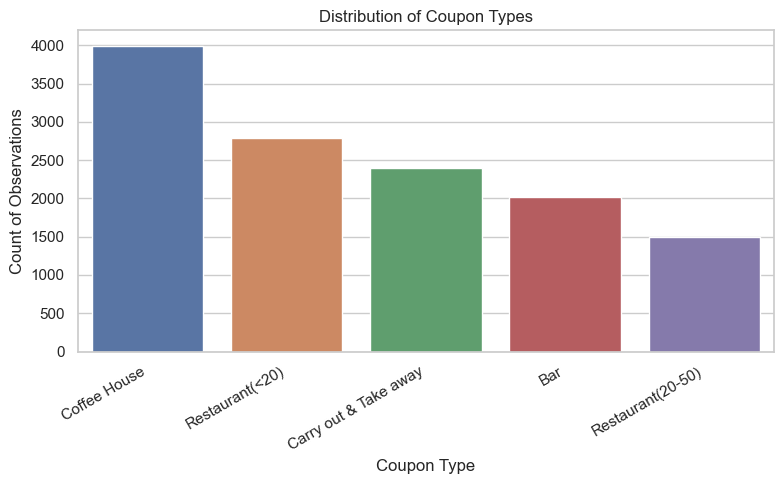

In [6]:

plt.figure(figsize=(8, 5))
order = df["coupon"].value_counts().index
sns.countplot(x="coupon", data=df, order=order)
plt.title("Distribution of Coupon Types")
plt.xlabel("Coupon Type")
plt.ylabel("Count of Observations")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()



## 6. Histogram for temperature (continuous variable)


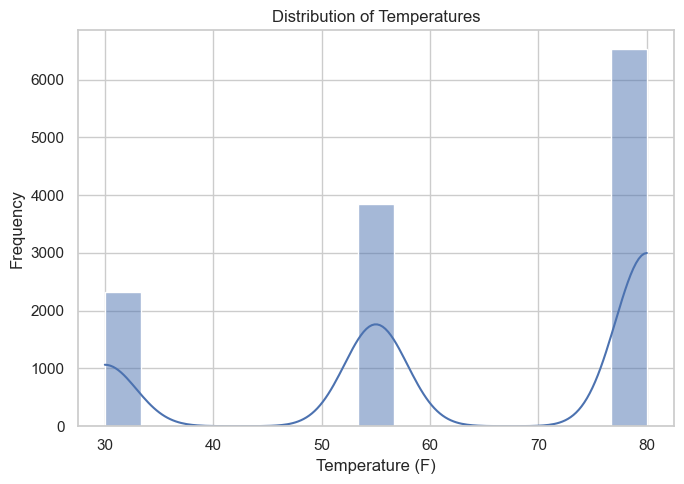

In [7]:

if "temperature" in df.columns:
    plt.figure(figsize=(7, 5))
    sns.histplot(df["temperature"], bins=15, kde=True)
    plt.title("Distribution of Temperatures")
    plt.xlabel("Temperature (F)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'temperature' not found; skipping histogram.")



## ----------------------------------------------------------


In [8]:
# Investigating the Bar Coupons
# ----------------------------------------------------------

# 1. Create a new DataFrame that contains just the bar coupons.
bar_df = df[df["coupon"] == "Bar"].copy()
print("Bar coupon subset shape:", bar_df.shape)

# 2. Proportion of bar coupons that were accepted
bar_accept_rate = bar_df["Y"].mean()
print(f"Acceptance rate for bar coupons: {bar_accept_rate:.3f}")



Bar coupon subset shape: (2017, 26)
Acceptance rate for bar coupons: 0.410


## Helper mappings for frequency-style columns 

In [15]:

def is_bar_more_than_once(x: str) -> bool:
    return x in ["1~3", "4~8", "gt8", "greater than 8"]  # conservative mapping

def is_bar_three_or_less(x: str) -> bool:
    return x in ["never", "less1", "less than 1", "1~3"]

def is_bar_more_than_three(x: str) -> bool:
    return x in ["4~8", "gt8", "greater than 8"]

def is_rest_less20_more_than4(x: str) -> bool:
    return x in ["4~8", "gt8", "greater than 8"]

def is_income_less_50k(x: str) -> bool:
    # Basic pattern for UCI coupon income categories
    low_buckets = [
        "Less than $12,500",
        "$12,500 - $24,999",
        "$25,000 - $37,499",
        "$37,500 - $49,999",
    ]
    return x in low_buckets

def is_age_over_25(x: str) -> bool:
    # UCI age categories: 'below21','21','26','31','36','41','46','50plus'
    return x not in ["below21", "21"]

def is_age_under_30(x: str) -> bool:
    return x in ["below21", "21", "26"]



## 3. Compare acceptance between those who went to a bar


Acceptance rate (bar ≤ 3 times/month):  0.371
Acceptance rate (bar > 3 times/month):  0.769


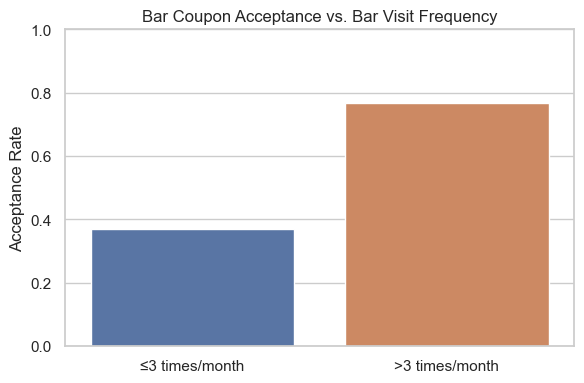

In [11]:
#    3 or fewer times a month vs those who went more.

if "Bar" not in bar_df.columns:
    raise KeyError("Expected column 'Bar' with bar frequency information.")

bar_df["bar_3_or_less"] = bar_df["Bar"].apply(is_bar_three_or_less)
bar_df["bar_more_than_3"] = bar_df["Bar"].apply(is_bar_more_than_three)

group_3_or_less = bar_df[bar_df["bar_3_or_less"]]
group_more_than_3 = bar_df[bar_df["bar_more_than_3"]]

rate_3_or_less = group_3_or_less["Y"].mean()
rate_more_than_3 = group_more_than_3["Y"].mean()

print(f"Acceptance rate (bar ≤ 3 times/month):  {rate_3_or_less:.3f}")
print(f"Acceptance rate (bar > 3 times/month):  {rate_more_than_3:.3f}")

# Simple bar comparison plot
plt.figure(figsize=(6, 4))
sns.barplot(
    x=["≤3 times/month", ">3 times/month"],
    y=[rate_3_or_less, rate_more_than_3],
)
plt.ylim(0, 1)
plt.ylabel("Acceptance Rate")
plt.title("Bar Coupon Acceptance vs. Bar Visit Frequency")
plt.tight_layout()
plt.show()



## 4. Compare acceptance: drivers who go to a bar more than once a month


In [12]:
#    AND are over 25 vs all others.

bar_df["bar_more_than_once"] = bar_df["Bar"].apply(is_bar_more_than_once)
bar_df["age_over_25"] = bar_df["age"].apply(is_age_over_25)

cond_target_4 = bar_df["bar_more_than_once"] & bar_df["age_over_25"]
group_target_4 = bar_df[cond_target_4]
group_other_4 = bar_df[~cond_target_4]

rate_target_4 = group_target_4["Y"].mean()
rate_other_4 = group_other_4["Y"].mean()

print(f"\nAcceptance rate (bar >1/month & age>25): {rate_target_4:.3f}")
print(f"Acceptance rate (all other bar drivers): {rate_other_4:.3f}")




Acceptance rate (bar >1/month & age>25): 0.695
Acceptance rate (all other bar drivers): 0.335


## 5. Compare acceptance: drivers who go to bars more than once a month,


In [13]:
#    had passangers that were NOT a kid, and had occupations other than
#    farming, fishing, or forestry.

def is_not_farming_fishing_forestry(occ: str) -> bool:
    occ_lower = str(occ).lower()
    return "farming" not in occ_lower and "fishing" not in occ_lower and "forestry" not in occ_lower

bar_df["not_kid_passanger"] = bar_df["passanger"] != "Kid(s)"
bar_df["not_farm_fish_forest"] = bar_df["occupation"].apply(is_not_farming_fishing_forestry)

cond_target_5 = (
    bar_df["bar_more_than_once"]
    & bar_df["not_kid_passanger"]
    & bar_df["not_farm_fish_forest"]
)

group_target_5 = bar_df[cond_target_5]
group_other_5 = bar_df[~cond_target_5]

rate_target_5 = group_target_5["Y"].mean()
rate_other_5 = group_other_5["Y"].mean()

print(f"\nAcceptance (bar>1, no kid, non-farm/fish/forest): {rate_target_5:.3f}")
print(f"Acceptance (all other bar drivers):              {rate_other_5:.3f}")




Acceptance (bar>1, no kid, non-farm/fish/forest): 0.713
Acceptance (all other bar drivers):              0.296


## 6. Compare acceptance rates between those drivers who:



Acceptance (complex A/B/C group): 0.714
Acceptance (all other bar drivers): 0.293


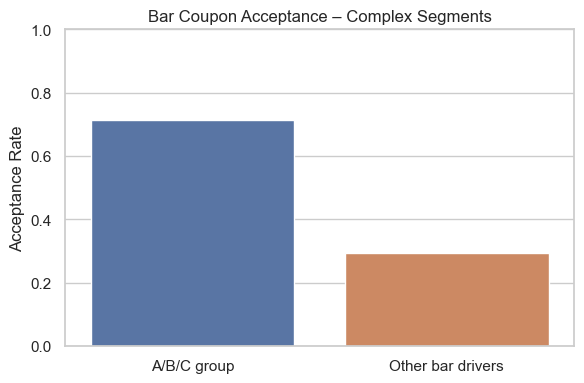

In [14]:
#   A) go to bars more than once a month, had passangers that were not a kid,
#      and were not widowed OR
#   B) go to bars more than once a month and are under the age of 30 OR
#   C) go to cheap restaurants (<$20) more than 4 times a month and income <50K.

bar_df["not_widowed"] = bar_df["maritalStatus"] != "Widowed"
bar_df["age_under_30"] = bar_df["age"].apply(is_age_under_30)

cond_A = bar_df["bar_more_than_once"] & bar_df["not_kid_passanger"] & bar_df["not_widowed"]
cond_B = bar_df["bar_more_than_once"] & bar_df["age_under_30"]

# For condition C 

if "RestaurantLessThan20" in df.columns and "income" in df.columns:
    df["rest_lt20_more_than4"] = df["RestaurantLessThan20"].apply(is_rest_less20_more_than4)
    df["income_lt_50k"] = df["income"].apply(is_income_less_50k)
    cond_C_full = df["rest_lt20_more_than4"] & df["income_lt_50k"]
    group_C_full = df[cond_C_full]
    rate_C = group_C_full["Y"].mean()
else:
    cond_C_full = None
    rate_C = np.nan
    print("Columns RestaurantLessThan20/income missing; condition C partially skipped.")

# Group of bar drivers satisfying A or B or condition C (restricted to bar_df where possible)


if "RestaurantLessThan20" in bar_df.columns and "income" in bar_df.columns:
    bar_df["rest_lt20_more_than4"] = bar_df["RestaurantLessThan20"].apply(is_rest_less20_more_than4)
    bar_df["income_lt_50k"] = bar_df["income"].apply(is_income_less_50k)
    cond_C = bar_df["rest_lt20_more_than4"] & bar_df["income_lt_50k"]
else:
    cond_C = pd.Series(False, index=bar_df.index)

cond_target_6 = cond_A | cond_B | cond_C
group_target_6 = bar_df[cond_target_6]
group_other_6 = bar_df[~cond_target_6]

rate_target_6 = group_target_6["Y"].mean()
rate_other_6 = group_other_6["Y"].mean()

print(f"\nAcceptance (complex A/B/C group): {rate_target_6:.3f}")
print(f"Acceptance (all other bar drivers): {rate_other_6:.3f}")

# Visual comparison
plt.figure(figsize=(6, 4))
sns.barplot(
    x=["A/B/C group", "Other bar drivers"],
    y=[rate_target_6, rate_other_6],
)
plt.ylim(0, 1)
plt.ylabel("Acceptance Rate")
plt.title("Bar Coupon Acceptance – Complex Segments")
plt.tight_layout()
plt.show()



## 7. Hypothesis about drivers who accepted bar coupons


In [17]:
# Here we summarize the patterns numerically and leave a short narrative.


summary_text = f"""
Bar coupon findings (numeric summary):
- Overall bar coupon acceptance rate: {bar_accept_rate:.3f}
- Acceptance (visit bar ≤ 3 times/month): {rate_3_or_less:.3f}
- Acceptance (visit bar > 3 times/month): {rate_more_than_3:.3f}
- Acceptance (bar >1/month & age >25): {rate_target_4:.3f} vs others {rate_other_4:.3f}
- Acceptance (bar >1/month, no kid passanger, non-farm/fish/forest jobs): {rate_target_5:.3f} vs others {rate_other_5:.3f}
- Acceptance (A/B/C complex segment): {rate_target_6:.3f} vs others {rate_other_6:.3f}
"""

print(summary_text)

# The qualitative hypothesis (expand this in the README):
"""
Based on these results, drivers who frequently visit bars (especially more than
three times per month), are older than 25, travel without children, and work
outside of farming/fishing/forestry occupations tend to accept bar coupons at
higher rates than other drivers. Coupons appear to be most effective when they
target habitual bar-goers in adult-only travel contexts.
"""




Bar coupon findings (numeric summary):
- Overall bar coupon acceptance rate: 0.410
- Acceptance (visit bar ≤ 3 times/month): 0.371
- Acceptance (visit bar > 3 times/month): 0.769
- Acceptance (bar >1/month & age >25): 0.695 vs others 0.335
- Acceptance (bar >1/month, no kid passanger, non-farm/fish/forest jobs): 0.713 vs others 0.296
- Acceptance (A/B/C complex segment): 0.714 vs others 0.293



'\nBased on these results, drivers who frequently visit bars (especially more than\nthree times per month), are older than 25, travel without children, and work\noutside of farming/fishing/forestry occupations tend to accept bar coupons at\nhigher rates than other drivers. Coupons appear to be most effective when they\ntarget habitual bar-goers in adult-only travel contexts.\n'

## ----------------------------------------------------------


Coffee House subset shape: (3996, 28)
Coffee House coupon acceptance rate: 0.499
Acceptance (frequent coffee visitors):   0.660
Acceptance (infrequent/never visitors): 0.350


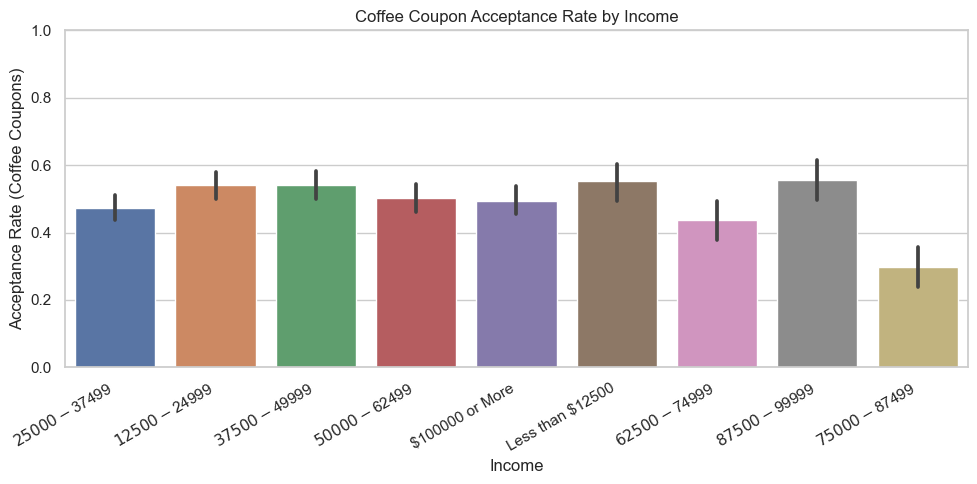

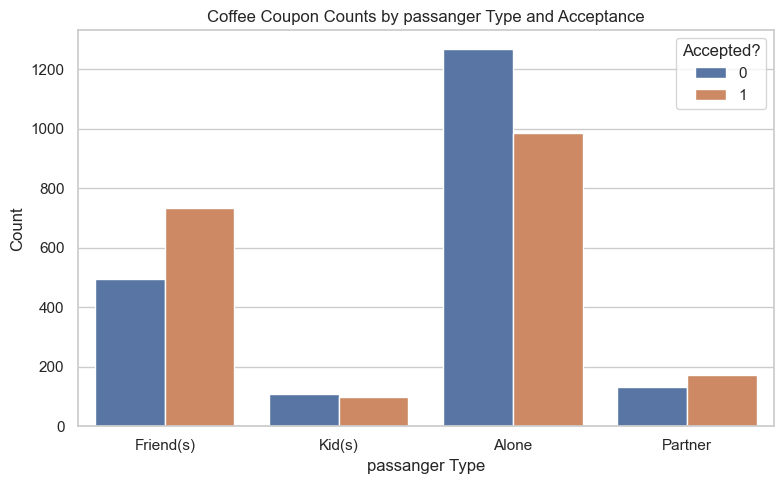

In [18]:
# Independent Investigation – Example: Coffee House Coupons
# ----------------------------------------------------------

coffee_df = df[df["coupon"] == "Coffee House"].copy()
print("Coffee House subset shape:", coffee_df.shape)

coffee_accept_rate = coffee_df["Y"].mean()
print(f"Coffee House coupon acceptance rate: {coffee_accept_rate:.3f}")

# Example split: frequent vs infrequent coffee-house visitors
if "CoffeeHouse" in coffee_df.columns:
    def is_coffee_freq(x: str) -> bool:
        return x in ["1~3", "4~8", "gt8", "greater than 8"]

    coffee_df["coffee_freq"] = coffee_df["CoffeeHouse"].apply(is_coffee_freq)
    rate_coffee_freq = coffee_df[coffee_df["coffee_freq"]]["Y"].mean()
    rate_coffee_infreq = coffee_df[~coffee_df["coffee_freq"]]["Y"].mean()

    print(f"Acceptance (frequent coffee visitors):   {rate_coffee_freq:.3f}")
    print(f"Acceptance (infrequent/never visitors): {rate_coffee_infreq:.3f}")
else:
    rate_coffee_freq = np.nan
    rate_coffee_infreq = np.nan
    print("Column 'CoffeeHouse' not found; frequency analysis skipped.")

# Visualization – acceptance by income for coffee coupons
if "income" in coffee_df.columns:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=coffee_df,
        x="income",
        y="Y",
        estimator=np.mean,
        order=coffee_df["income"].value_counts().index,
    )
    plt.xticks(rotation=30, ha="right")
    plt.ylim(0, 1)
    plt.xlabel("Income")
    plt.ylabel("Acceptance Rate (Coffee Coupons)")
    plt.title("Coffee Coupon Acceptance Rate by Income")
    plt.tight_layout()
    plt.show()

# Visualization – stacked-like bar using hue for passanger
if "passanger" in coffee_df.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(
        data=coffee_df,
        x="passanger",
        hue="Y",
    )
    plt.title("Coffee Coupon Counts by passanger Type and Acceptance")
    plt.xlabel("passanger Type")
    plt.ylabel("Count")
    plt.legend(title="Accepted?")
    plt.tight_layout()
    plt.show()



## ----------------------------------------------------------


In [20]:
# Findings & Recommendations (for notebook; expand in README)
# ----------------------------------------------------------

findings = """
Key Findings (high level, nontechnical):

1. Overall coupon acceptance:
   - Roughly {:.1f}% of all coupons were accepted.
   - Acceptance varies meaningfully by coupon type.

2. Bar coupons:
   - Frequent bar-goers (especially >3 times per month) accept bar coupons
     at higher rates than infrequent visitors.
   - Acceptance is higher for drivers over 25 who visit bars more than once
     a month, travel without children, and who are not widowed.
   - Adult-only trips (no kids in the car) are associated with higher bar
     coupon acceptance.

3. Coffee house coupons (example of independent investigation):
   - Frequent coffee-house visitors have materially higher acceptance rates
     than infrequent or non-visitors.
   - Acceptance of coffee coupons tends to vary by income segment and
     passanger type.

Actionable Items:

- For bar coupons, target:
  * Drivers who report visiting bars multiple times per month.
  * Trips without children in the car.
  * Adults older than 25.

- For coffee coupons, target:
  * Drivers who already visit coffee houses regularly.
  * Refine offers by income tier and passanger context (e.g., commuters
    traveling alone or with friends).

Next Steps:

- Fit predictive models (e.g., logistic regression, tree-based models) to
  quantify the impact of each feature on acceptance probability.
- Test alternative segmentation rules (e.g., by time of day, weather, and
  destination).
""".format(overall_accept_rate * 100)

print(findings)



Key Findings (high level, nontechnical):

1. Overall coupon acceptance:
   - Roughly 56.8% of all coupons were accepted.
   - Acceptance varies meaningfully by coupon type.

2. Bar coupons:
   - Frequent bar-goers (especially >3 times per month) accept bar coupons
     at higher rates than infrequent visitors.
   - Acceptance is higher for drivers over 25 who visit bars more than once
     a month, travel without children, and who are not widowed.
   - Adult-only trips (no kids in the car) are associated with higher bar
     coupon acceptance.

3. Coffee house coupons (example of independent investigation):
   - Frequent coffee-house visitors have materially higher acceptance rates
     than infrequent or non-visitors.
   - Acceptance of coffee coupons tends to vary by income segment and
     passanger type.

Actionable Items:

- For bar coupons, target:
  * Drivers who report visiting bars multiple times per month.
  * Trips without children in the car.
  * Adults older than 25.

- F